In [2]:
%matplotlib inline
%precision 3

import numpy as np
import pandas as pd
from numpy.random import randn
from numpy import corrcoef, arange
np.random.seed(123)
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 10


import datetime

from numpy import nan as NA

#### Data loading & Reading

In [5]:
!head NCDB_1999_to_2014_s.csv

In [6]:
accident=pd.read_csv('NCDB_1999_to_2014_s.csv', engine='python')

In [7]:
#Replace all column heads to lower case
accident.columns = accident.columns.map(lambda x: x[:].lower())
accident

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,2013,06,2,12,2,02,21,02,1,1,...,02,01,2005,01,M,28,11,2,02,1
1,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,01,F,42,11,1,02,1
2,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,02,M,04,12,2,01,2
3,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,03,F,33,98,2,UU,U
4,2013,06,2,08,2,02,36,02,1,1,...,01,01,2005,01,F,44,11,2,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491543,2014,UU,U,UU,2,UU,UU,01,U,U,...,13,07,UUUU,01,M,24,11,1,NN,1
491544,2014,UU,U,23,2,01,06,05,1,1,...,01,14,2006,01,M,29,96,2,09,5
491545,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
491546,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U


In [8]:
#Sorth the values of the selected columns (ascending)
accident=accident.sort_values(['c_year','c_mnth','c_wday','c_hour'], ascending = True)

In [9]:
#Copy of the dataset
data=accident[:]

#Convert any non-numeric value to np.Nan (I applied these to the columns I'm using for my analysis)
data[['c_mnth','c_wday','c_hour','c_sev','c_vehs','c_conf','p_psn','p_safe']] = data[['c_mnth','c_wday','c_hour','c_sev','c_vehs','c_conf','p_psn','p_safe']].replace('^([A-Za-z])+$', np.nan, regex=True)
data = data.dropna()

In [10]:
#Slice the columns for my section of the data analysis
df = data.loc[:,['c_year','c_mnth','c_wday','c_hour','c_sev','c_vehs','c_conf','p_psn','p_safe']]

In [11]:
#This process is to eliminate the '0' preceding a single digit number. ex. 01 --> 1, converting str objects to int
df[['c_vehs','c_conf','p_safe']] = df[['c_vehs','c_conf','p_safe']].fillna(-1).astype(int)
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,p_psn,p_safe
374,2013,06,2,00,2,2,36,11,2
881,2013,06,2,00,2,1,6,11,2
882,2013,06,2,00,2,1,6,13,2
888,2013,06,2,00,2,2,3,11,2
889,2013,06,2,00,2,2,3,96,9
...,...,...,...,...,...,...,...,...,...
491041,2014,12,7,23,2,2,21,11,1
491042,2014,12,7,23,2,2,21,11,2
491320,2014,12,7,23,2,1,33,11,9
491372,2014,12,7,23,2,1,4,11,2


In [12]:
#Generate the date-time column "date", and assign it as the index.
df['date'] = pd.PeriodIndex(df['c_year'].map(str) + '-' + df['c_mnth'], freq='M')
#df=df.set_index('date')

#### 1.1 Number of Vehicles involved in collision & Time relation

In [13]:
#Number of vehicles invovled in collision over time
df1 = df.loc[:,['date','c_vehs']]
vehs=df1.groupby(['date','c_vehs']).size().unstack()
vehs

c_vehs,1,2,3,4,5,6,7,8,9,10,...,16,17,18,20,21,36,37,39,43,57
date,,,,,,,,,,,,,,,,,,,,,
2013-06,3009.0,9796.0,2296.0,557.0,114.0,51.0,7.0,9.0,NaN,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07,3925.0,13851.0,2772.0,681.0,177.0,42.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08,3943.0,13982.0,2966.0,662.0,212.0,51.0,8.0,11.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09,3758.0,13271.0,2834.0,562.0,233.0,14.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10,4063.0,13306.0,3014.0,759.0,138.0,46.0,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08,3626.0,12398.0,2583.0,740.0,151.0,32.0,26.0,NaN,17.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,3230.0,12188.0,2665.0,679.0,130.0,45.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,3438.0,12761.0,2756.0,662.0,149.0,50.0,22.0,8.0,NaN,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,0,'Date')

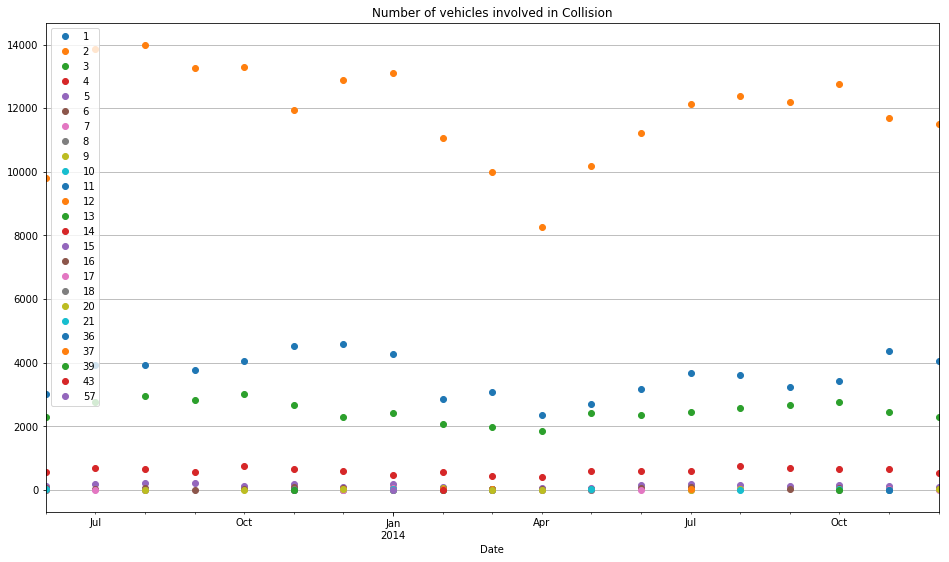

In [14]:
#Visualize the result
vehs.iloc[:].plot(style = 'o', figsize=(16,9), title = 'Number of vehicles involved in Collision')
plt.legend(loc=2)
plt.grid(axis='y')
plt.xlabel('Date')

Text(0.5,0,'Number of vehicles involved in each collision')

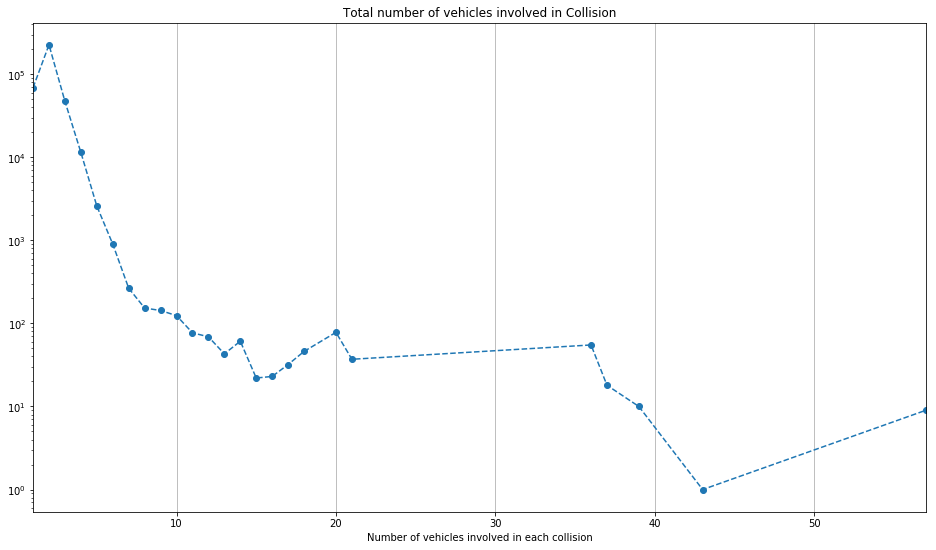

In [15]:
#Total number of vehicles involved in collision 
df2=df1.groupby('c_vehs').size().sort_index()

df2.plot(style='o--',logy=True,figsize=(16,9),title='Total number of vehicles involved in Collision')
plt.grid(axis='x');
plt.xlabel('Number of vehicles involved in each collision')

The most likely number of vehicles involved in collision was 2. 

Text(0,0.5,'Weekday')

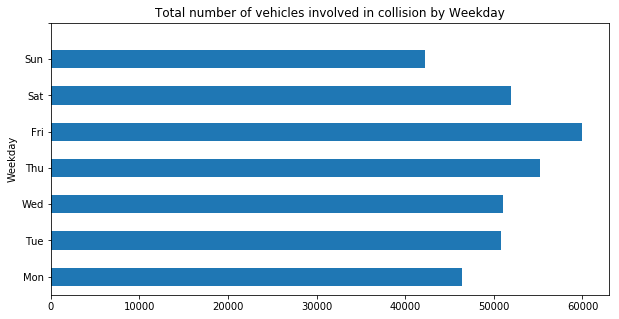

In [16]:
#Total number of vehicles involved in collision in regards to weekday
df3 = df.loc[:,['c_wday','c_vehs']]
weekday=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
w_day= df3.groupby('c_wday')['c_vehs'].size()

#Visualize the result
w_day.plot(kind='barh',figsize=(10,5),rot =0, title='Total number of vehicles involved in collision by Weekday')
plt.yticks(range(0,8),weekday)
plt.ylabel('Weekday')

Text(0.5,0,'Weekday')

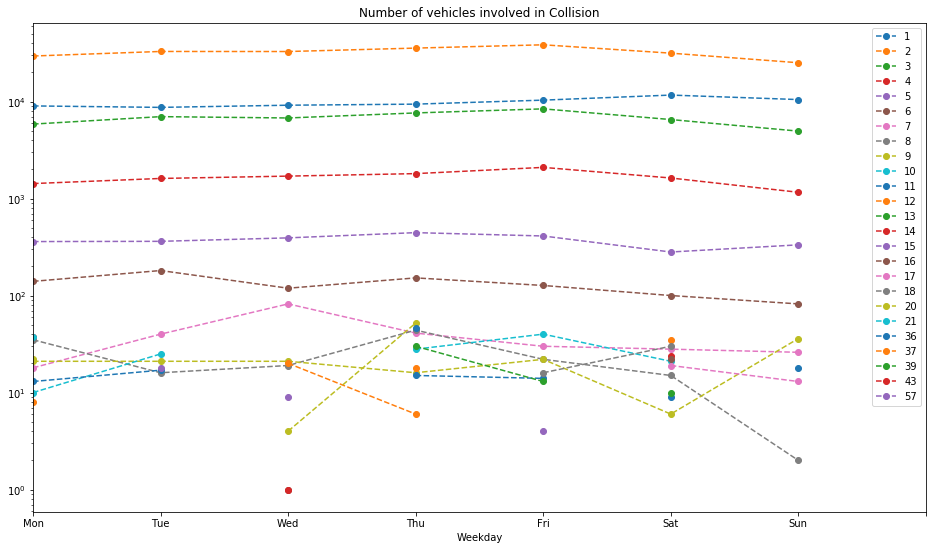

In [17]:
#Relationship of number of vehicles involved in collision (1-57 vehicles) on a specific weekday 
w_day1=df3.groupby(['c_wday','c_vehs']).size().unstack()
w_day1
w_day1.iloc[:].plot(logy=True,style = 'o--', figsize=(16,9), title = 'Number of vehicles involved in Collision')
plt.legend(loc='best')
plt.xticks(range(0,8),weekday)
plt.xlabel('Weekday')

In [18]:
# Slice the data with just Number of vehicles involved in collision & hour
df4= df.loc[:,['c_hour','c_vehs']]
df4

,c_hour,c_vehs
374,00,2
881,00,1
882,00,1
888,00,2
889,00,2
...,...,...
491041,23,2
491042,23,2
491320,23,1
491372,23,1


Text(0.5,0,'Hour')

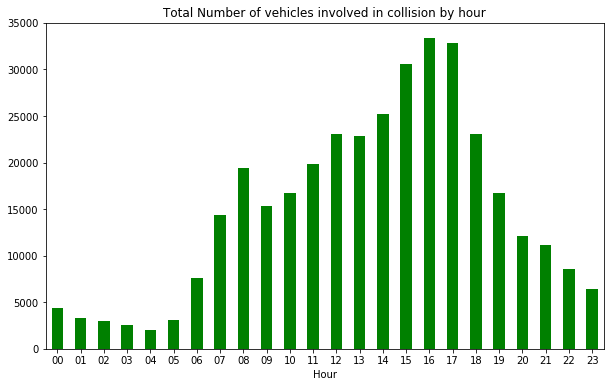

In [19]:
#Total Number of vehicles involved in collision by hour
hour=df4.groupby('c_hour')['c_vehs'].size()
hour.plot(kind='bar',title='Total Number of vehicles involved in collision by hour',color='G',rot=0)
plt.xlabel('Hour')

Text(0.5,0,'Hour')

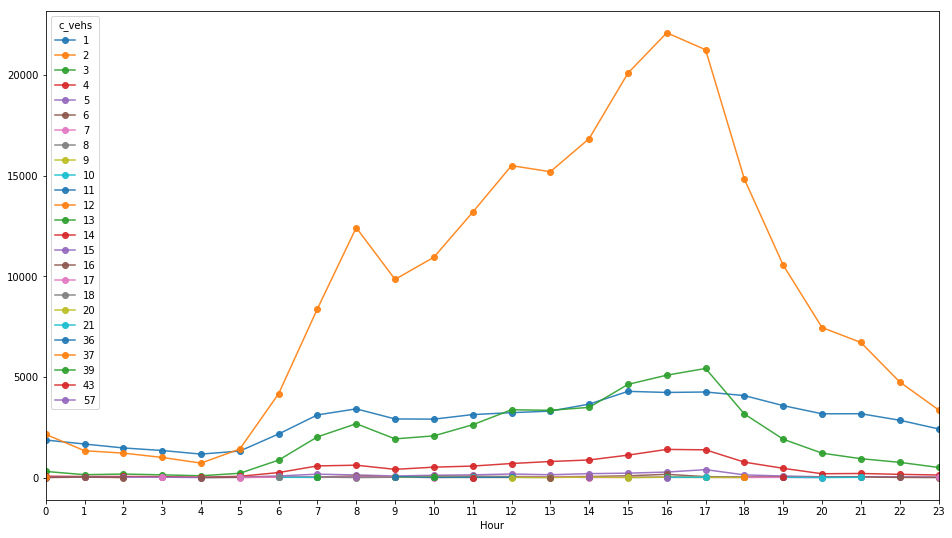

In [20]:
#Number of vehicles involved in collisions at different hours
hour1 = df4.groupby(['c_hour','c_vehs']).size().unstack()
hour1.plot(figsize=(16,9),style='o-',alpha=0.9)
plt.xticks(range(0,24),range(0,24))
plt.xlabel('Hour')

#### 1.2 Number of Vehicles involved in collision & collision severity 

c_sev == 1 (fatal)
c_sev == 2 (non-fatal)

In [21]:
#Relationship between number of vehicles involved in collision and Collision severity

df5=df.loc[:,['c_vehs','c_sev']]
vehs_sev= df5.groupby(['c_vehs','c_sev']).size().unstack()
vehs_sev

c_sev,1,2
c_vehs,,
1,1773.0,66940.0
2,2473.0,223076.0
3,672.0,46422.0
4,141.0,11285.0
5,40.0,2545.0
...,...,...
36,NaN,55.0
37,18.0,NaN
39,NaN,10.0


Text(0,0.5,'Number of collisions')

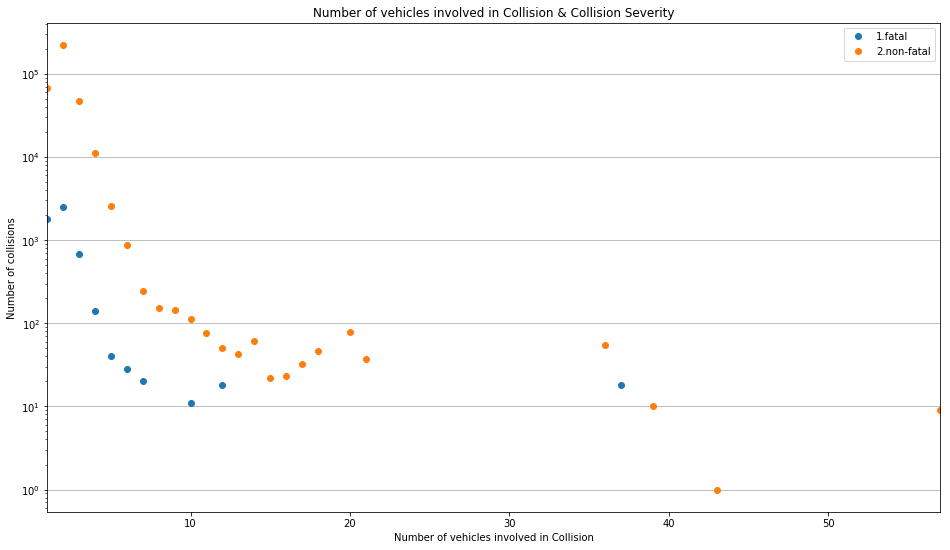

In [73]:
#Plot the new dataframe in logarithm, since the gap between numbers are huge.
vehs_sev.iloc[:].plot(logy=True,style = 'o', figsize=(16,9), title = 'Number of vehicles involved in Collision & Collision Severity')
plt.grid(axis='y')
plt.legend(['1.fatal','2.non-fatal'])
plt.xlabel('Number of vehicles involved in Collision') 
plt.ylabel('Number of collisions')

#### 1.3 Number of vehicles involved in collision & Collision configuration

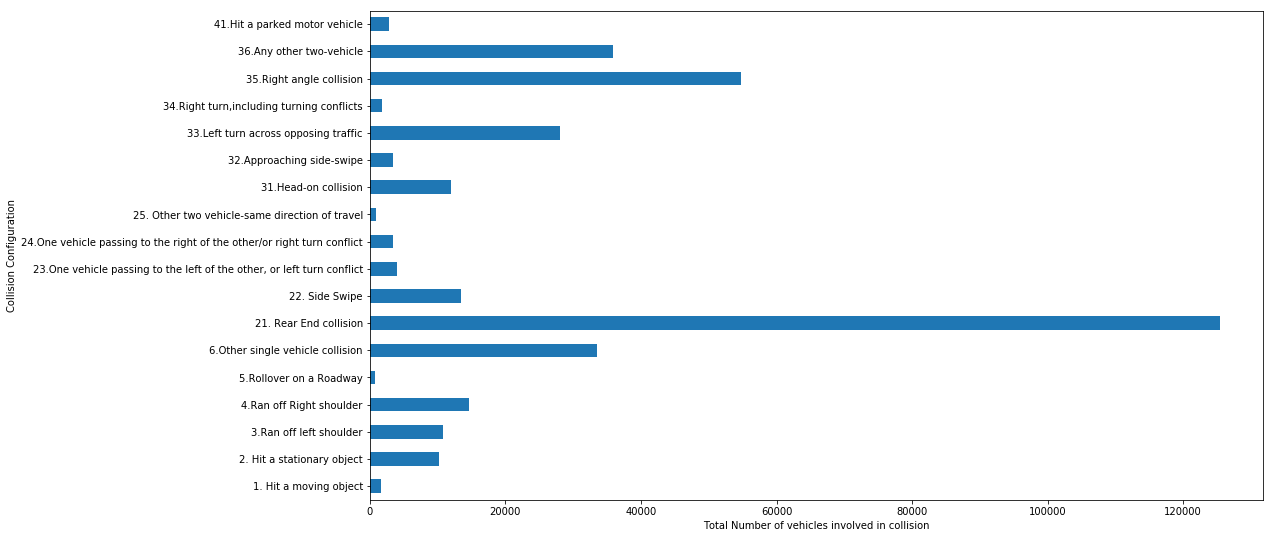

In [23]:
#Number of vehicles involved in collision & Collision configuration
conf=['1. Hit a moving object','2. Hit a stationary object', '3.Ran off left shoulder','4.Ran off Right shoulder','5.Rollover on a Roadway',
      '6.Other single vehicle collision', '21. Rear End collision', '22. Side Swipe','23.One vehicle passing to the left of the other, or left turn conflict',
      '24.One vehicle passing to the right of the other/or right turn conflict','25. Other two vehicle-same direction of travel',
      '31.Head-on collision','32.Approaching side-swipe','33.Left turn across opposing traffic','34.Right turn,including turning conflicts',
      '35.Right angle collision','36.Any other two-vehicle','41.Hit a parked motor vehicle']
vehs_conf=df.groupby('c_conf')['c_vehs'].count().sort_index(ascending=True)
vehs_conf
vehs_conf.plot(figsize=(16,9), kind='barh', rot=0)
plt.xlabel('Total Number of vehicles involved in collision')
plt.ylabel('Collision Configuration')
plt.yticks(np.arange(0,18),conf);

In [56]:
df6 = df.loc[:,['c_vehs','c_conf']].groupby(['c_vehs','c_conf']).size().unstack().T
df6.index = df6.index.astype(str)
df6

c_vehs,1,2,3,4,5,6,7,8,9,10,...,16,17,18,20,21,36,37,39,43,57
c_conf,,,,,,,,,,,,,,,,,,,,,
1,1568.0,22.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9957.0,163.0,51.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10210.0,451.0,119.0,31.0,6.0,6.0,NaN,NaN,NaN,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14073.0,393.0,96.0,15.0,7.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,791.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,598.0,24351.0,2739.0,334.0,45.0,27.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,165.0,1536.0,114.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,476.0,48264.0,5016.0,850.0,101.0,42.0,NaN,2.0,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


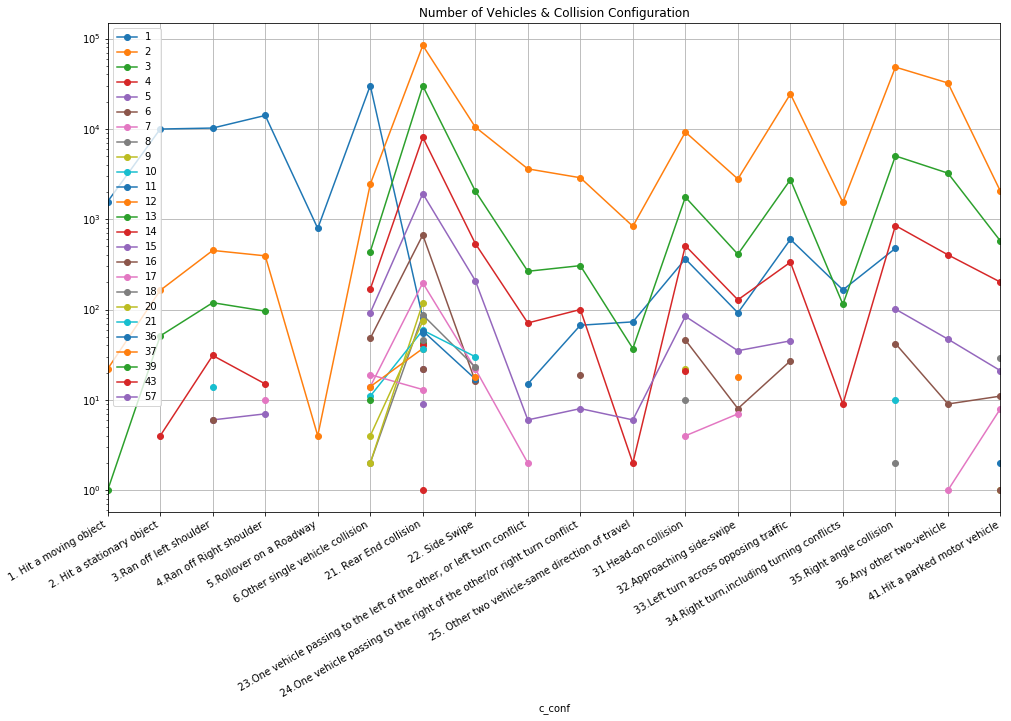

In [54]:
df6.plot(style = 'o-',logy=True, figsize =(16,9),title='Number of Vehicles & Collision Configuration')
plt.legend()
plt.xticks(np.arange(0,18),conf,rotation=30,ha='right')
plt.grid()

#### 2.1 Collision configuration & Date

In [26]:
df7 = df.loc[:,['date','c_conf']]
configuration=df7.groupby(['date','c_conf']).size().unstack()
configuration

c_conf,1,2,3,4,5,6,21,22,23,24,25,31,32,33,34,35,36,41
date,,,,,,,,,,,,,,,,,,
2013-06,93,456,399,584,62,1575,5763,591,130,152,29,440,132,1143,67,2432,1687,125
2013-07,101,571,622,910,59,1828,7696,865,281,253,61,592,145,1560,118,3244,2399,151
2013-08,82,564,627,864,74,1978,7950,868,296,260,51,557,195,1601,106,3128,2461,174
2013-09,120,481,508,721,39,2039,7793,804,230,157,44,491,94,1605,78,3026,2243,199
2013-10,104,567,533,684,33,2278,7796,741,259,193,29,581,187,1609,126,2898,2525,189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08,93,461,651,893,55,1577,7000,757,257,234,26,580,217,1397,86,3090,2027,174
2014-09,96,451,504,704,47,1573,7099,619,260,187,51,506,135,1450,118,2860,2137,140
2014-10,104,521,535,651,36,1727,7259,715,187,171,39,491,133,1614,105,3264,2162,171


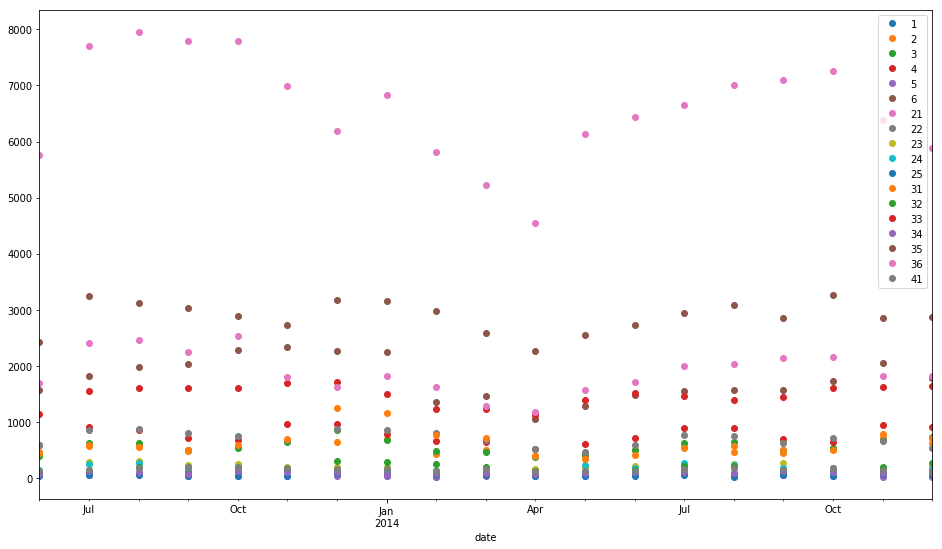

In [27]:
configuration.plot(style='o',figsize=(16,9))
plt.legend()

#### 2.2 Collision configuration & Collision severity

In [28]:
df8 = df.loc[:,['c_conf','c_sev']]
conf_sev= df8.groupby(['c_conf','c_sev']).size().unstack()
conf_sev
conf_sev.index= conf_sev.index.astype(str)

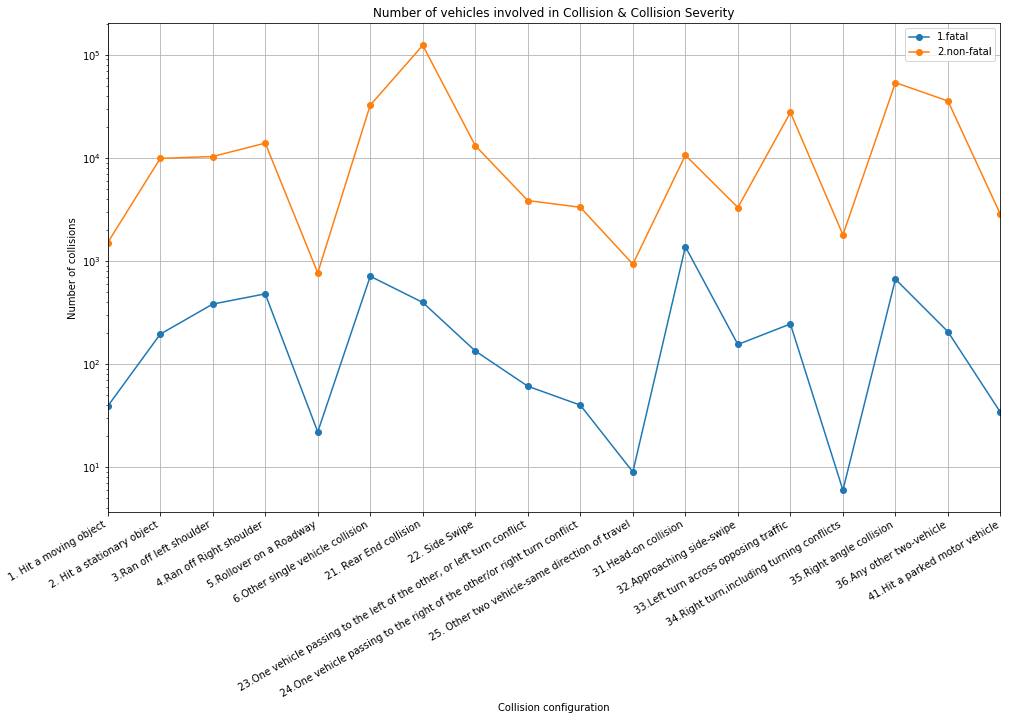

In [228]:
conf_sev.plot(logy=True,style = 'o-', figsize=(16,9), title = 'Number of vehicles involved in Collision & Collision Severity')
plt.grid()
plt.legend(['1.fatal','2.non-fatal'])
plt.xlabel('Collision configuration') 
plt.ylabel('Number of collisions')
plt.xticks(np.arange(0,18),conf,rotation=30,ha='right');

#### 3.1 Person Position & severity

In [35]:
position=['11.Driver','12.Front.row,center','13.Front row, right outboard, including motorcycle passenger in sidecar',
          '21.Second row, left outboard, including motorcycle passenger','22.Second row, center','23.Second row, right outboard',
          '31.Third row, left outboard','32.Third row, center','33.Third row, right outboard','96.Position unknown, but the person was definitely an occupant',
          '97.Sitting on someone’s lap','98.Outside passenger compartment','99.Pedestrian']
df9=df.loc[:,['p_psn','c_sev']]
psn_sev= df9.groupby(['p_psn','c_sev']).size().unstack()
psn_sev

c_sev,1,2
p_psn,,
11,3265,242024
12,83,4872
13,874,56495
21,230,15015
22,100,5131
...,...,...
33,16,504
96,176,3101
97,1,25


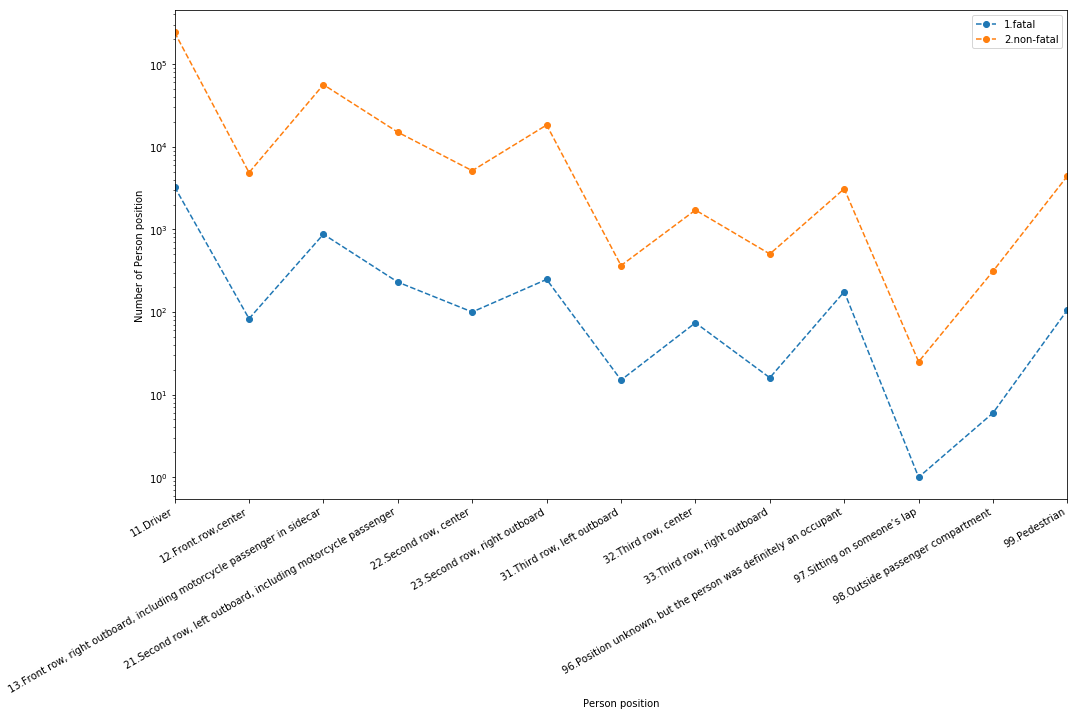

In [71]:
psn_sev.plot(logy=True, style='o--',figsize=(16,9))
plt.legend(['1.fatal','2.non-fatal'])
plt.ylabel('Number of Person position')
plt.xlabel('Person position')
plt.xticks(np.arange(0,13),position,rotation=30,ha='right');

In [45]:
df10=df.loc[:,['p_psn','c_conf']]
psn_conf= df10.groupby(['p_psn','c_conf']).size().unstack().T
psn_conf.index=psn_conf.index.astype(str)

In [52]:
"""psn_conf.plot(style='o--',logy=True, figsize=(16,9))
plt.legend(loc='best')
plt.ylabel('Number of collisions')
plt.xlabel('Person position')
plt.xticks(np.arange(0,18),conf,rotation=30,ha='right')""";

#### 4. Safety device used 

In [68]:
df11=df.loc[:,['date','p_safe']]
saf_date= df11.groupby(['date','p_safe']).size().unstack()

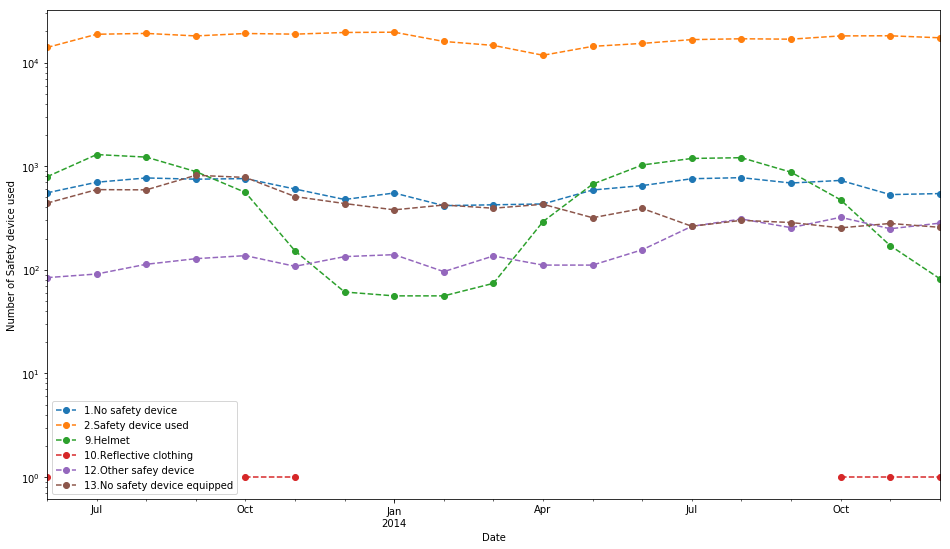

In [70]:
safety=['1.No safety device','2.Safety device used','9.Helmet','10.Reflective clothing','12.Other safey device','13.No safety device equipped']

saf_date.plot(logy=True, style='o--',figsize=(16,9))
plt.legend(safety)
plt.ylabel('Number of Safety device used')
plt.xlabel('Date');